## Super-Resolution Application with CPS
- infer gene expression with higher resolution of spatial position

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2026'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior'
args.radius=150
args.clusters=6
args.hvgs=2000
args.er_w=0.05
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=256, clusters=6, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MBSS_Sagittal_Posterior', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2026, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3355 2000 torch.Size([2, 22953])


In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:5.7543, T:2.5622, S:2.4066, D:0.7854]

Epoch 100: Train[Total:2.5985, T:1.0224, S:1.0374, D:0.5388]

Epoch 200: Train[Total:2.3830, T:0.9895, S:1.0015, D:0.3920]

Epoch 300: Train[Total:2.2708, T:0.9743, S:0.9844, D:0.3121]

Epoch 400: Train[Total:2.1718, T:0.9635, S:0.9729, D:0.2355]

Epoch 500: Train[Total:2.0944, T:0.9555, S:0.9646, D:0.1743]

Epoch 600: Train[Total:2.0348, T:0.9495, S:0.9583, D:0.1269]

Epoch 700: Train[Total:1.9904, T:0.9444, S:0.9531, D:0.0930]

Epoch 800: Train[Total:1.9595, T:0.9406, S:0.9485, D:0.0703]

Epoch 900: Train[Total:1.9352, T:0.9369, S:0.9448, D:0.0536]

Epoch 999: Train[Total:1.9177, T:0.9336, S:0.9421, D:0.0420]


### prepare and generate the super-resolution gene expression

In [8]:
show_genes = [
    'Pcp2',    # 小脑浦肯野细胞层 (最强推荐：展示断点连成线)
    'Mbp',     # 白质/髓鞘 (展示复杂纹理：生命之树结构)
    'Hpca',    # 海马体 CA1 区 (展示极致精细的弯曲结构)
    'Calb1',   # 小脑浦肯野细胞 (Pcp2 的备选，信号很强)
    'Gabra6',  # 小脑颗粒细胞层 (与 Pcp2 形成互补结构)
    'Cux2',    # 大脑皮层 Layer 2/3 (展示层级边界)
    'Foxp2',   # 大脑皮层 Layer 6 (与 Cux2 对比展示分层)
    'Car8'     # 小脑浦肯野细胞 (另一种标记)
]

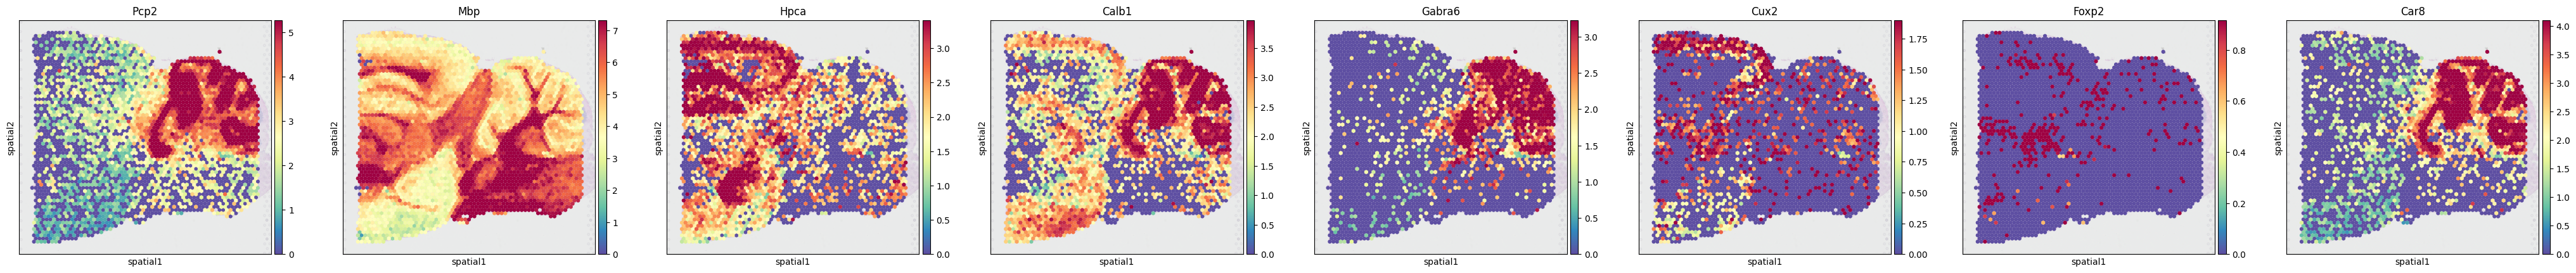

In [9]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pl.spatial(adata_hvg, color=show_genes, spot_size=150, color_map='Spectral_r',alpha_img=0.3,vmax='p90', ncols=8, wspace=0.)

### Super-res factor

In [10]:
# mask_ratio=0 to get all the inference data
imputed_expr, z_s = cps_model.infer_postion(pyg_data)
adata_sr1 = adata_hvg.copy()
adata_sr1.layers['imputed'] = imputed_expr.detach().cpu().numpy()
adata_sr1.obsm['z_s'] = z_s.detach().cpu().numpy()
adata_sr1.X = np.log1p(adata_sr1.layers['imputed'])
adata_sr1

AnnData object with n_obs × n_vars = 3355 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'z_s'
    layers: 'counts', 'imputed'

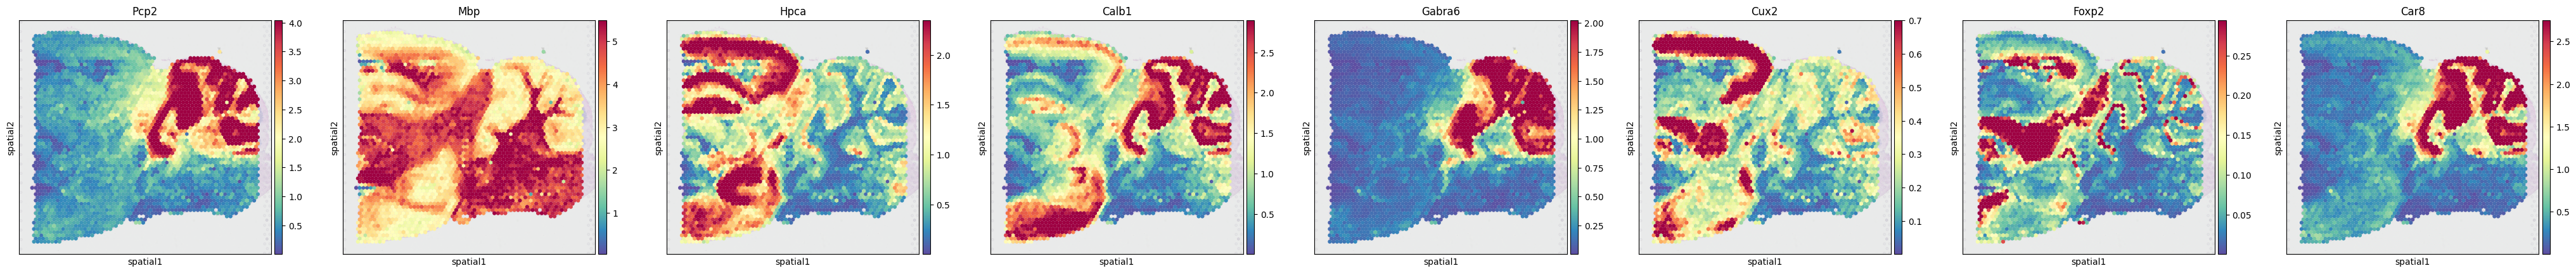

In [11]:
sc.pl.spatial(
    adata_sr1, 
    color=show_genes, 
    spot_size=150, 
    color_map='Spectral_r', 
    vmax='p90',
    alpha_img=0.3,         
    ncols=8,
    wspace=0.
)

In [12]:
# generate high-res coords
sr_coords = CPS.generate_sr_coords(adata_hvg, upscale_factor=2)
# norm and adapt to INR input
min_val = torch.FloatTensor(adata.obsm['spatial']).min(dim=0).values
max_val = torch.FloatTensor(adata.obsm['spatial']).max(dim=0).values
center = (min_val + max_val) / 2
span = max_val - min_val
scale = span.max() / 2
sr_coords_tensor = torch.FloatTensor(sr_coords)
sr_pos_norm = (sr_coords_tensor - center) / scale
# generate the library size for NB distribution
sr_lib_size = CPS.generate_sr_library_size(adata_hvg, sr_coords, mode='median', k=0)
cps_model.model.eval()
with torch.no_grad():
    z_s = cps_model.model.student(sr_pos_norm.to(cps_model.device))
    sr_expr, _ = cps_model.model.decoder(z_s, sr_lib_size.to(cps_model.device))
adata_sr2 = CPS.construct_sr_adata(adata_hvg, sr_expr, z_s.cpu().numpy(), sr_coords, use_log1p=True)

num of raw spots: 3355
num of generation spots: 14500
filter bg SR num: 11939
Generating Library Size with mode: median


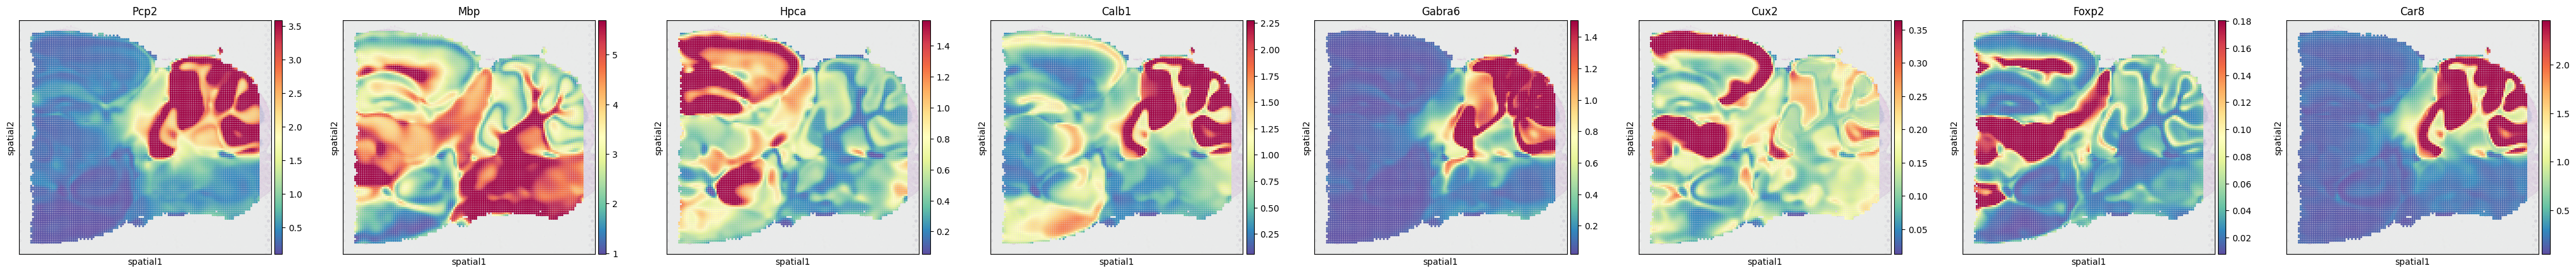

In [13]:
import matplotlib.pyplot as plt
sc.pl.spatial(
    adata_sr2, 
    color=show_genes, 
    spot_size=75, 
    color_map='Spectral_r', 
    vmax='p90',
    alpha_img=0.3,         
    ncols=8,
    wspace=0.
)


In [14]:
# generate high-res coords
sr_coords = CPS.generate_sr_coords(adata_hvg, upscale_factor=4)
# norm and adapt to INR input
min_val = torch.FloatTensor(adata.obsm['spatial']).min(dim=0).values
max_val = torch.FloatTensor(adata.obsm['spatial']).max(dim=0).values
center = (min_val + max_val) / 2
span = max_val - min_val
scale = span.max() / 2
sr_coords_tensor = torch.FloatTensor(sr_coords)
sr_pos_norm = (sr_coords_tensor - center) / scale
# generate the library size for NB distribution
sr_lib_size = CPS.generate_sr_library_size(adata_hvg, sr_coords, mode='median', k=0)
cps_model.model.eval()
with torch.no_grad():
    z_s = cps_model.model.student(sr_pos_norm.to(cps_model.device))
    sr_expr, _ = cps_model.model.decoder(z_s, sr_lib_size.to(cps_model.device))
adata_sr4 = CPS.construct_sr_adata(adata_hvg, sr_expr, z_s.cpu().numpy(), sr_coords, use_log1p=True)

num of raw spots: 3355
num of generation spots: 57519
filter bg SR num: 47744
Generating Library Size with mode: median


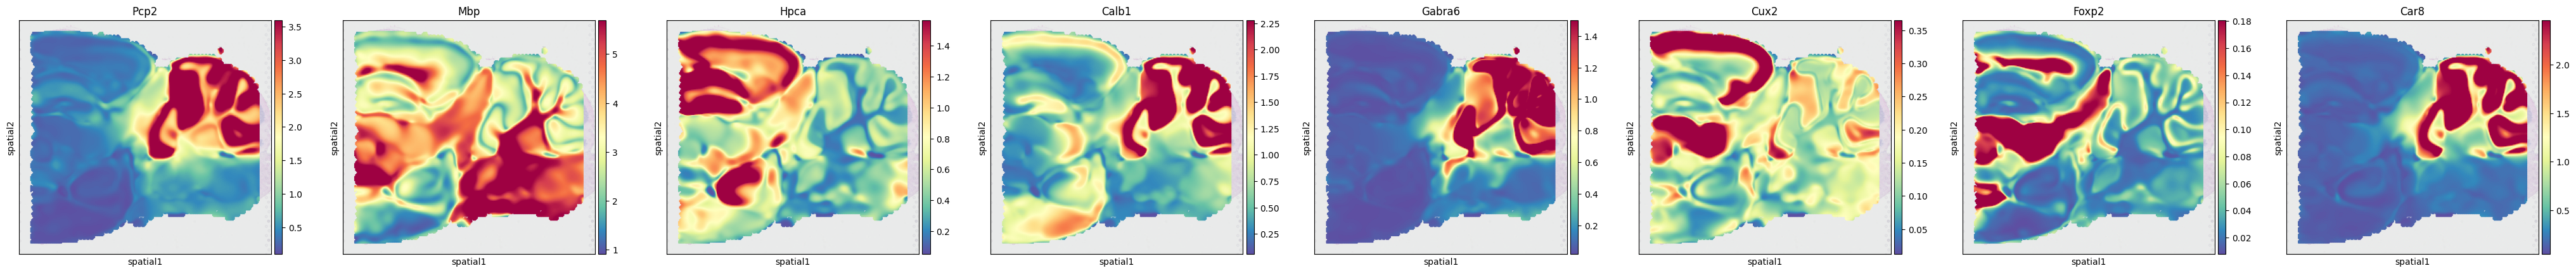

In [15]:
sc.pl.spatial(
    adata_sr4, 
    color=show_genes, 
    spot_size=60, 
    color_map='Spectral_r',
    vmax='p90',
    alpha_img=0.3,         
    ncols=8,
    wspace=0.0,
)

In [16]:
# generate high-res coords
sr_coords = CPS.generate_sr_coords(adata_hvg, upscale_factor=6)
# norm and adapt to INR input
min_val = torch.FloatTensor(adata.obsm['spatial']).min(dim=0).values
max_val = torch.FloatTensor(adata.obsm['spatial']).max(dim=0).values
center = (min_val + max_val) / 2
span = max_val - min_val
scale = span.max() / 2
sr_coords_tensor = torch.FloatTensor(sr_coords)
sr_pos_norm = (sr_coords_tensor - center) / scale
# generate the library size for NB distribution
sr_lib_size = CPS.generate_sr_library_size(adata_hvg, sr_coords, mode='median', k=0)
cps_model.model.eval()
with torch.no_grad():
    z_s = cps_model.model.student(sr_pos_norm.to(cps_model.device))
    sr_expr, _ = cps_model.model.decoder(z_s, sr_lib_size.to(cps_model.device))
adata_sr6 = CPS.construct_sr_adata(adata_hvg, sr_expr, z_s.cpu().numpy(), sr_coords, use_log1p=True)

num of raw spots: 3355
num of generation spots: 129058
filter bg SR num: 107268
Generating Library Size with mode: median


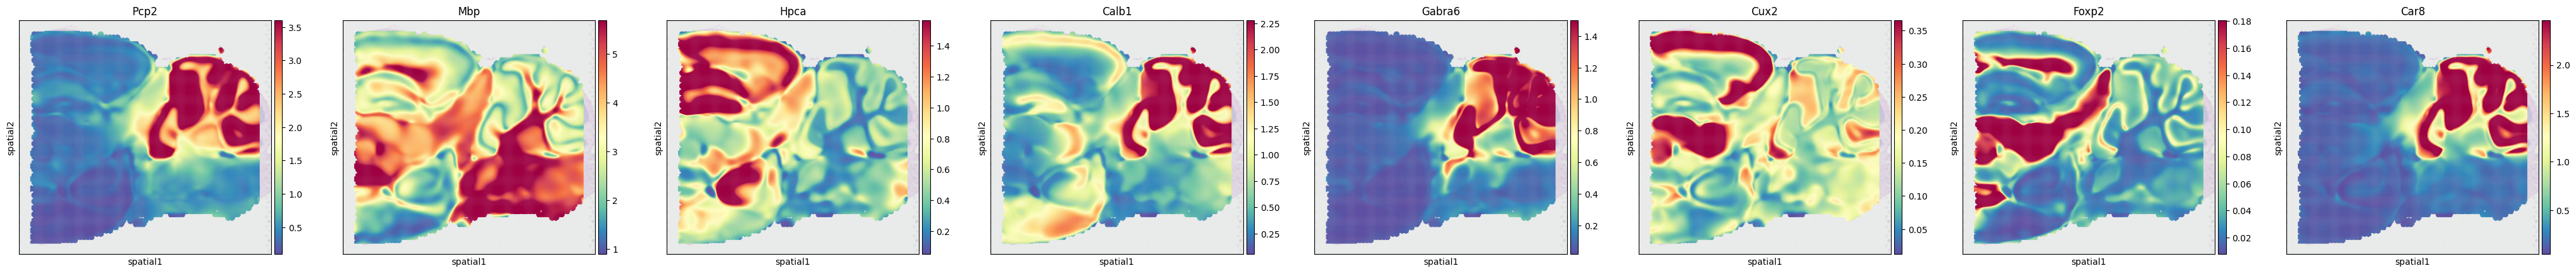

In [17]:
sc.pl.spatial(
    adata_sr6, 
    color=show_genes, 
    spot_size=35, 
    color_map='Spectral_r',
    vmax='p90',
    alpha_img=0.3,         
    ncols=8,
    wspace=0.0,
)

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# ==========================================
# 核心函数 1: 计算 Moran's I (空间连续性)
# ==========================================
def calc_morans_i_safe(adata, gene):
    """
    计算 Moran's I，自动处理稀疏矩阵和邻居图构建
    """
    try:
        # 1. 确保有空间邻居图 (懒加载)
        if 'neighbors' not in adata.uns:
            # print(f"Computing neighbors for {adata.shape[0]} spots...")
            sc.pp.neighbors(adata, use_rep='spatial', n_neighbors=15)
            
        # 2. 获取表达量并转为 Dense Array (关键修复)
        X_data = adata[:, gene].X
        if hasattr(X_data, "toarray"):
            vals = X_data.toarray().flatten()
        else:
            vals = X_data.flatten()
            
        # 3. 计算 Moran's I
        m_i = sc.metrics.morans_i(adata, vals=vals)
        
        # 4. 处理返回值 (Scanpy 有时返回数组)
        if isinstance(m_i, np.ndarray):
            return m_i[0]
        return m_i
        
    except Exception as e:
        # print(f"Error in MoransI for {gene}: {e}")
        return np.nan

# ==========================================
# 核心函数 2: 计算 Robust CNR (对比信噪比)
# ==========================================
def calc_cnr_robust(adata, gene, percentile=80):
    """
    计算 CNR，引入 Log1p 和 Epsilon 防止 Raw Data 虚高
    """
    try:
        # 1. 获取数据
        X_data = adata[:, gene].X
        expr = X_data.toarray().flatten() if hasattr(X_data, "toarray") else X_data.flatten()
        
        # 2. 【关键修正】统一做 Log1p 处理
        # 如果数据最大值超过 20 (说明可能是 Raw Counts)，就做 log1p
        # 如果数据很小 (说明已经是 log 过的)，就保持原样
        # if np.max(expr) > 20:
        #     expr = np.log1p(expr)
            
        # 3. 动态确定 ROI 阈值
        threshold = np.percentile(expr, percentile)
        
        # 4. 分割前景 (Signal) 和 背景 (Noise)
        signal_roi = expr[expr > threshold]
        signal_bg = expr[expr <= threshold]
        
        if len(signal_roi) == 0 or len(signal_bg) == 0: return np.nan
        
        # 5. 计算统计量
        mu_roi, std_roi = np.mean(signal_roi), np.std(signal_roi)
        mu_bg, std_bg = np.mean(signal_bg), np.std(signal_bg)
        
        # 6. 【关键修正】分母加 Epsilon，防止 Raw 背景方差为 0 导致 CNR 爆炸
        epsilon = 1e-6
        denom = np.sqrt(std_roi**2 + std_bg**2) + epsilon
        
        return np.abs(mu_roi - mu_bg) / denom
        
    except Exception as e:
        return np.nan


In [19]:
# 1. 准备数据字典
datasets_dict = {
    'Raw Visium': adata_hvg,
    'CPS SR x1': adata_sr1,  # Student Inference (Denoised but same res)
    'CPS SR x2': adata_sr2,
    'CPS SR x4': adata_sr4,
    'CPS SR x6': adata_sr6
}

# 2. 批量计算循环
all_results = []
print(f"Comparing {len(datasets_dict)} datasets across {len(show_genes)} genes...")

for method_name, adata_curr in datasets_dict.items():
    print(f"Processing {method_name}...")
    
    # 预计算邻居 (加速后续 Moran's I)
    if 'neighbors' not in adata_curr.uns:
        sc.pp.neighbors(adata_curr, use_rep='spatial', n_neighbors=15)
        
    for gene in show_genes:
        if gene in adata_curr.var_names:
            mi = calc_morans_i_safe(adata_curr, gene)
            cnr = calc_cnr_robust(adata_curr, gene, percentile=90) # 使用新的 Robust 函数
            
            all_results.append({
                'Method': method_name,
                'Gene': gene,
                'MoransI': mi,
                'CNR': cnr
            })

# 3. 生成 DataFrame 并强制类型转换
df_all = pd.DataFrame(all_results)
df_all[['MoransI', 'CNR']] = df_all[['MoransI', 'CNR']].astype(float)

print("Calculation Done!")
display(df_all.head())

Comparing 5 datasets across 8 genes...
Processing Raw Visium...
Processing CPS SR x1...
Processing CPS SR x2...
Processing CPS SR x4...
Processing CPS SR x6...
Calculation Done!


Method    Gene   MoransI       CNR
0  Raw Visium    Pcp2  0.764620  2.549768
1  Raw Visium     Mbp  0.846062  2.018836
2  Raw Visium    Hpca  0.527159  1.904642
3  Raw Visium   Calb1  0.620687  2.145742
4  Raw Visium  Gabra6  0.763440  3.165378

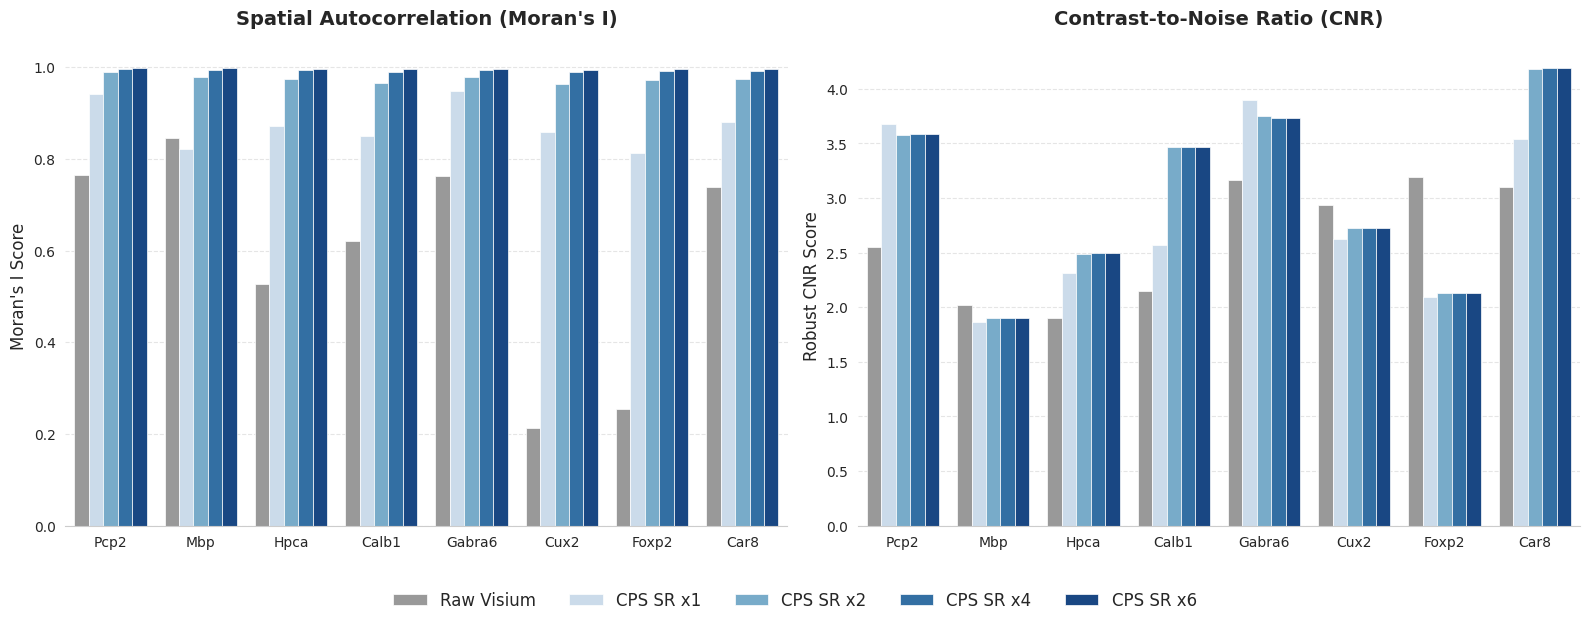

In [23]:
# 设置风格
sns.set_style("whitegrid", {'axes.grid': False}) # 关闭默认网格，后面手动加Y轴网格
plt.rcParams['font.family'] = 'sans-serif' # 确保字体清晰
custom_palette = {
    'Raw Visium': '#999999',  # 中灰 (Baseline)
    'CPS SR x1':  '#c6dbef',  # 极浅蓝 (Student Inference)
    'CPS SR x2':  '#6baed6',  # 浅蓝
    'CPS SR x4':  '#2171b5',  # 中蓝
    'CPS SR x6':  '#084594'   # 深蓝 (高分辨率)
}
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Moran's I ---
sns.barplot(data=df_all, x='Gene', y='MoransI', hue='Method', 
            palette=custom_palette, ax=axs[0], errorbar=None,
            edgecolor='white', linewidth=0.5) # 给柱子加个白边，更精致
axs[0].set_title("Spatial Autocorrelation (Moran's I)", fontsize=14, fontweight='bold', pad=15)
axs[0].set_ylabel("Moran's I Score", fontsize=12)
axs[0].set_xlabel("")
axs[0].grid(axis='y', linestyle='--', alpha=0.5) # 只开Y轴网格
axs[0].get_legend().remove() # 移除子图自带图例

# --- Plot 2: CNR ---
sns.barplot(data=df_all, x='Gene', y='CNR', hue='Method', 
            palette=custom_palette, ax=axs[1], errorbar=None,
            edgecolor='white', linewidth=0.5)
axs[1].set_title("Contrast-to-Noise Ratio (CNR)", fontsize=14, fontweight='bold', pad=15)
axs[1].set_ylabel("Robust CNR Score", fontsize=12)
axs[1].set_xlabel("")
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].get_legend().remove() # 移除子图自带图例

# --- 全局美化 ---
sns.despine(left=True) # 去掉左边和上边的边框线，看起来更现代

# --- 关键：创建一个共用图例放在底部 ---
# 获取 handles 和 labels (从第一个图拿就行，因为是一样的)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=5, frameon=False, fontsize=12) # ncol=5 表示一行排5个

plt.tight_layout(rect=[0, 0.05, 1, 1]) # 给底部图例留出 5% 的空间
plt.show()

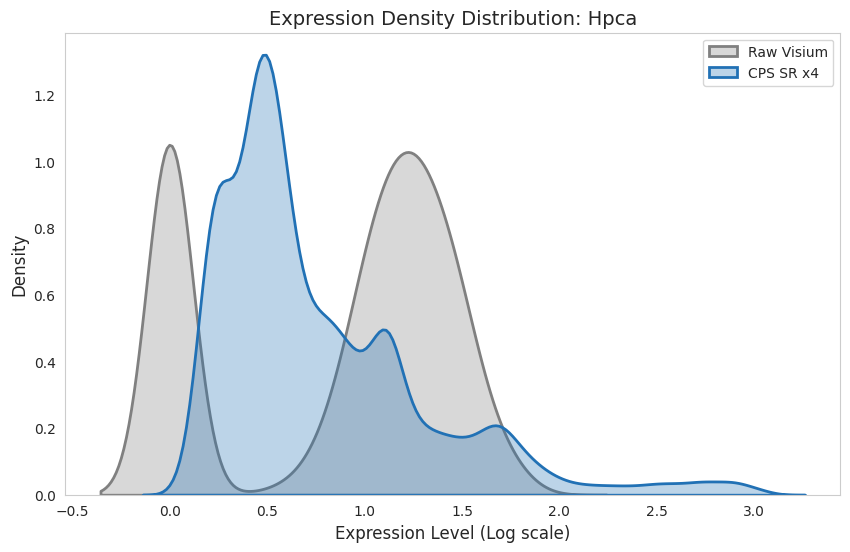

In [21]:
# 选择一个代表性基因
# gene_target = 'Pcp2' # 小脑标记
gene_target = 'Hpca' # 海马标记

plt.figure(figsize=(10, 6))

# 1. 画 Raw Data (通常在 0 附近有一个巨大的 Dropout 峰)
raw_expr = adata_hvg[:, gene_target].X
raw_vals = raw_expr.toarray().flatten() if hasattr(raw_expr, "toarray") else raw_expr.flatten()
sns.kdeplot(np.log1p(raw_vals), fill=True, color='grey', label='Raw Visium', alpha=0.3, linewidth=2)

# 2. 画 CPS SR x4 (应该能看到清晰的双峰：背景峰 vs 信号峰)
sr_expr = adata_sr4[:, gene_target].X
sr_vals = sr_expr.toarray().flatten() if hasattr(sr_expr, "toarray") else sr_expr.flatten()
# 注意：如果 SR 输出已经是 log 过的，就不要再 log1p，否则会压扁。这里假设 SR 输出类似 log count。
sns.kdeplot(sr_vals, fill=True, color='#2171b5', label='CPS SR x4', alpha=0.3, linewidth=2)

plt.title(f'Expression Density Distribution: {gene_target}', fontsize=14)
plt.xlabel('Expression Level (Log scale)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

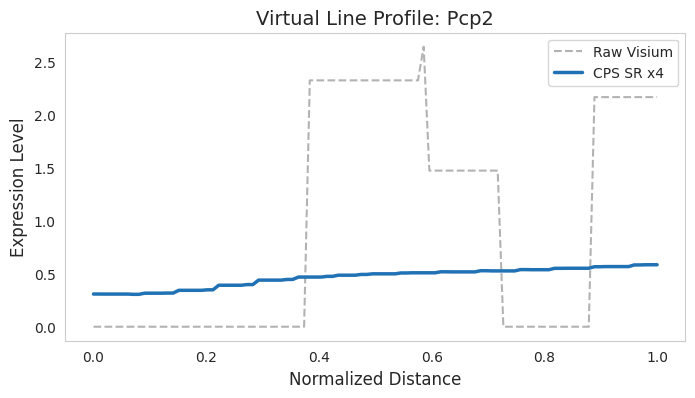

In [22]:
# === 定义切线 ===
# 提示：先看 sc.pl.spatial 确定坐标范围
# 这里的坐标仅为示例，请根据你的 adata_hvg.obsm['spatial'] 范围修改
start_point = np.array([3000, 5000]) 
end_point =   np.array([3500, 5500]) 
gene_line = 'Pcp2'

# === 计算切片数值 ===
num_points = 100
line_points = np.linspace(start_point, end_point, num_points)
distances = np.linspace(0, 1, num_points)

# 1. Raw Data 取值
tree_raw = KDTree(adata_hvg.obsm['spatial'])
dists_raw, idxs_raw = tree_raw.query(line_points, k=1)
raw_vals = adata_hvg[:, gene_line].X.toarray().flatten()[idxs_raw]

# 2. SR x4 取值
tree_sr = KDTree(adata_sr4.obsm['spatial'])
dists_sr, idxs_sr = tree_sr.query(line_points, k=1)
sr_vals = adata_sr4[:, gene_line].X.flatten()[idxs_sr]

# === 绘图 ===
plt.figure(figsize=(8, 4))
plt.plot(distances, raw_vals, label='Raw Visium', color='grey', linestyle='--', alpha=0.6)
plt.plot(distances, sr_vals, label='CPS SR x4', color='#2171b5', linewidth=2.5) # Science Blue

plt.title(f'Virtual Line Profile: {gene_line}', fontsize=14)
plt.xlabel('Normalized Distance', fontsize=12)
plt.ylabel('Expression Level', fontsize=12)
plt.legend()
plt.show()